<img src=attachment:88c90614-07ea-4ccb-aab3-7b63dc27a603.png width=400, height=41>

Author: [Jonathan Windgassen](mailto:j.windgassen@fz-juelich.de)
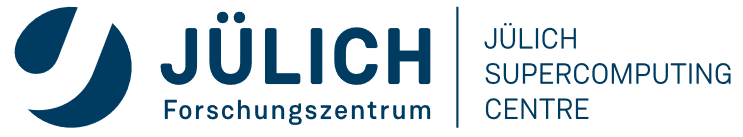

# Python Face Blurer

This Script will scan any images in the *Images*-folder or any videos in the *Video*-folder for faces/persons using the [Faster RCNN Open Images V4 Neural Network](https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1) and apply a blur to all findings.



#### Table of Contents:
1. Initializing the Project
    - Creating the Folder Structure
    - Imports
    - Configuration
2. Initializing the Blur
    - Functions for bluring objects
    - Functions for drawing boxes
3. Loading the Classifier
    - Pulling the Classifier
    - Input and Output Parsing
4. Fetching all Images and Video
5. Run Classifier and Apply Blur
    - Run Classifier over every Image and Video
    - Save to Output folder
    - Compact Frames into a Video
6. Cleanup

-----------------------------------------------------

## Initializing the Project

### Creating the Folder Structure

For Python to find the Images and Videos it needs the path to the folders where the Images are stored. By default the notebook expects the following folder structure, but you can change the paths below if you want:
<pre>
├── face_blurer.ipynb
├── Images
│   ├── Image.png
│   └── ...
├── Images_Out
├── Videos
│   ├── Video.mp4
│   └── ...
└── Videos_Out
</pre>

Usage:
- **Images**: Put all Images here that you want to have blured. OpenCV can load almost all file formats, but for a complete list look [here](https://docs.opencv.org/3.4/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56).
- **Images_Out**: After processing the new Images will be placed here. The name of the processed file can be specified in the config with *FILENAME_AFTER_BLURRING*.
- **Videos**: Same deal as with the Images. Put all Videos here that you want to have processed.
- **Videos_Out**: All processed Videos will be placed here after applying the algorithm. The new name will be the same as for the Images.

> Note: If you want to load the files from a different place in storage you can do so by editing the variable in the configuration. More on that below! 

### Imports

#### *Please use the PyDeepLearning*-kernel or the kernel from **kernel.ipynb** to run this

Import everything we need for the whole operation.
- The main package for the model will be tensorflow, which will internally use [TensorflowHub](https://tfhub.dev/) to download the network.
- We will apply the blur using PIL, the Python Image Library that nativly gets delivered with python.
- matplotlib will be used to display images in the notebook. Usefull if you want to see the results of the blurring directly.

In [ ]:
#######################################
# Disable GPU Usage for TensorFlow
#######################################
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Main package for the ANN
import tensorflow as tf
import tensorflow_hub as hub

# Opening Files and Bluring
import cv2 as cv
import numpy as np

# Displaying the image
import matplotlib.pyplot as plt

from time import time            # For measuring the inference time.
from os import listdir           # Getting available files
import re                        # Config
import tempfile
import shutil

print("tensorflow version: " + tf.__version__)
print("OpenCV version: " + cv.__version__)

# Check available GPU devices.
print("\nNum GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))

### Configuration

Here you can configure every aspect of the algorithm

The most interesting option is probably *FILTER_OBJETCS*, where you can specify what object should be detected/blurred. You can see all available object classes in [this image](https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy_visualizer/circle.html) or take a direct look at the [Open Image Dataset](https://storage.googleapis.com/openimages/web/visualizer/index.html?). The filter is interpreted as a Regex, so you can also filter for multiple classes, eg. by chaining them together with `|` or using wildcard symbols like `.`. In most cases you'll probably want to use `Person` or `Human face`

In [ ]:
FILTER_OBJECTS = "Person"  # Regex. What Object you want to detect. Everything else will be ignored.
FILENAME_AFTER_BLURRING = "{}_blured"  # {} replaces the original filename. Don't add the extension (.jpg, .mp3) here
DRAW_BOXES = False
BLUR_OBJECTS = True
BLUR_INTENSITY = 20
EXTEND_BOXES = 20  # Increases the size of the boxes by x pixels in each direction

FORCE_IMAGE_SIZE = (None, None)  # Leave at None for no changes. You are free to only resize one Dimension and leave the other
FORCE_VIDEO_SIZE = (None, None)  # Same as above
CROP_VIDEO_LENGTH = None         # Time in seconds after which videos will be cropped. Recommended for testing

VIDEO_CACHE_FOLDER = None  # Before we output the final video all frames will be saved as a .png-file in a folder. If you specify a folder here they won't be deleted afterwards. Leave None to use a tempdir.
FORCE_VIDEO_FORMAT = None  # Leave None for Original. You must not include the preceding "."
VIDEO_BITRATE = None  # String or Integer. Leave None for default
ENCODER = "h264"           # E.g. "h264", "hevc"(h265), "asv1" (AV1)

# When paths are relative the origin will be the folder where this notebook is. You MUST put an / behind the folder paths
IMAGE_INPUT_FOLDER = "./Images/"
IMAGE_OUTPUT_FOLDER = "./Images_Out/"
VIDEO_INPUT_FOLDER = "./Videos/"
VIDEO_OUTPUT_FOLDER = "./Videos_Out/"

----------------------
## Initializing the Blur

### Functions for bluring objects

In [ ]:
def blur_objects(image, boxes, names, confidence, min_score=0.1):
    """
    Apply the results from the network to the image and blur the objects specified above.
    
    From the network return values we need to pass where the objects are, what each object is and how confident the network if about the detection.
    Since those properties are given in seperate lists, each identified object needs to be in the same index for every parameter.
    
    :param image:      (numpy.ndarray) The image to be drawn on.
    :param boxes:      (numpy.ndarray) An Array of shape (n, 4) with the 4 coordinates for each box. Cordinate must be [ymin, xmin, ymax, xmax]
    :param names:      (numpy.ndarray) An Array of shape (n) with the name of each Object.
    :param confidence: (numpy.ndarray) An Array of shape (n) with the confidence for each Object.
    :param min_score:  (optional, int) The required confidence for the box to be applied
    """
    
    for i in range(boxes.shape[0]):
        is_confident = confidence[i] >= min_score
        is_in_filter = re.search(FILTER_OBJECTS, names[i]) is not None
            
        if is_confident and is_in_filter:
            blur_object(image, boxes[i])


def blur_object(image, coordinates, intensity=BLUR_INTENSITY):
    height, width = image.shape[:2]
    (ymin, xmin, ymax, xmax) = coordinates
    
    (x, w, y, h) = (int(xmin * width), int(xmax * width), int(ymin * height), int(ymax * height))
    
    # Blur the area of the face
    sub_image = image[y:h, x:w]
    sub_image = cv.blur(sub_image, (intensity, intensity))

    # Apply blurred face back to image
    image[y:h, x:w] = sub_image

### Functions for drawing boxes

In [ ]:
def draw_boxes(image, boxes, names, confidence, min_score=0.1):
    """
    Apply the results from the network to the image and draw a box around each identified object.
    
    From the network return values we need to pass where the boxes are, what object each box represents and confident the network if about the detection.
    Since those properties are given in seperate lists, each identified object needs to be in the same index for every parameter.
    
    :param image:      (numpy.ndarray) The image to be drawn on.
    :param boxes:      (numpy.ndarray) An Array of shape (n, 4) with the 4 coordinates for each box. Cordinate must be [ymin, xmin, ymax, xmax]
    :param names:      (numpy.ndarray) An Array of shape (n) with the name of each Object.
    :param confidence: (numpy.ndarray) An Array of shape (n) with the confidence for each Object.
    :param min_score:  (optional, int) The required confidence for the box to be applied
    """
    
    for i in range(boxes.shape[0]):
        is_confident = confidence[i] >= min_score
        is_in_filter = re.search(FILTER_OBJECTS, names[i]) is not None
            
        if is_confident and is_in_filter:
            display_str = f"{names[i]}: {int(100 * confidence[i])}%"
            draw_bounding_box_on_image(image, boxes[i], display_str)


def draw_bounding_box_on_image(image, coordinates, label="", color=(0, 0, 255), thickness=4):
    """
    Adds a bounding box to an image.
    
    :param image:       (np.ndarray) The Image to be drawn on.
    :param coordinates: (tuple) Coordinates of the Box: (ymin, xmin, ymax, xmax). Each coordinate must be between 0 and 1.
    :param color:       (optional, str) 7-digit String representing the Color in the format of '#rrggbb'.
    :param thickness:   (optional, int) How thick the box should be.
    """
    # Draw the Box itself
    height, width = image.shape[:2]
    (left, top) = (int(coordinates[1] * width) - EXTEND_BOXES, int(coordinates[0] * height) - EXTEND_BOXES)
    (width, height) = (int(coordinates[3] * width) - left + 2 * EXTEND_BOXES, int(coordinates[2] * height) - top + 2 * EXTEND_BOXES)
    
    image = cv.rectangle(image, (left, top, width, height), color, thickness)
    
    # Calculate text specs
    (width, height), _ = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.6, 1)
    height += 10
    width += 10
    position = top if top < height else top - height  # Move label to the inside if not enough space above the box
    
    # Draw Text
    rect = (left, position, width, height)
    image = cv.rectangle(image, rect, color, -1)
    image = cv.putText(image, label, (left + 5, position + height - 5), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255))

--------------
## Loading the Classifier

### Pulling the Classifier

Here we use tensorflow_hub to Pull the ANN from the [Tensorflow Hub](https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1). Be aware that depending on your setup the loading can take a few minutes.

In [ ]:
module_handle = "./model"
classifier = hub.load(module_handle).signatures['default']

# Input and Output Parsing

These Functions will load an Image as an numpy.ndarray, which will then be passed to *run_detector*, were they will be converted to the right format and passed to the classifier

In [ ]:
def display_image(image):
    """Displays the image to the screen."""
    plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.axis("off")
    
    plt.imshow(image)


def open_image(path, display=False, resolution=FORCE_IMAGE_SIZE):
    """
    Open and format an image from disk.
    
    Open a picture from file in the path variable. After if gets resized and converted to RGB if neccesary. If chosen if will also be displayed. 
    
    :param path:    (str) The path to the Picture.
    :param display: (boolean, optional) Whether you want the image displayed
    :param width:   (tuple, optional) The desired resolution after rescaling.
    """
    image = cv.imread(path, cv.IMREAD_COLOR)
    
    if (resolution != (None, None)):
        width = resolution[0] or image.shape[1]
        height = resolution[1] or image.shape[0]
        
        image = cv.resize(image, dsize=(width, height), interpolation=cv.INTER_CUBIC)
    
    if display:
        display_image(image)
    
    return image


def run_detector(detector, image):
    """
    Runs the given classifier on the given image. Only works with detectors that accept the same input format as the original one.
    
    
    :param detector: (A trackable Object) The Classifier.
    :param image:    (np.ndarray) The Image.
    :return:         (Dict) A Dictionary with the objects found by the Classifier.
    """
    img = image.astype(np.float32)
    img = np.expand_dims(img, axis=0)  # add required additional dimension. Same as img[np.newaxis, :], but better readable
    img /= 255  # Normalize
    
    result = detector(tf.convert_to_tensor(img))
    
    # Extract the numeric values
    result = {key: value.numpy() for key, value in result.items()}
    result["detection_class_entities"] = [name.decode('ascii') for name in result["detection_class_entities"]]
    
    return result

--------------
## Fetching all Images and Videos

In [ ]:
images = listdir(IMAGE_INPUT_FOLDER)
videos = listdir(VIDEO_INPUT_FOLDER)

# Remove hidden files (Starting with .) and convert to an tuple with (name, format)
images = [[file.split(".")[0], file.split(".")[-1]] for file in images if not file.startswith(".")]
videos = [[file.split(".")[0], file.split(".")[-1]] for file in videos if not file.startswith(".")]

print(f"Found {len(images)} Images")
print(f"Found {len(videos)} Videos")

---------------------

## Run Classifier and Blur

### Run Classifier on every Image

In [ ]:
for file in images:
    image = open_image(IMAGE_INPUT_FOLDER + file[0] + "." + file[1])
    start_time = time()
    
    #######################################
    # Code that failes
    #######################################
    result = run_detector(classifier, image)
        
    if BLUR_OBJECTS:
        blur_objects(image, result["detection_boxes"], result["detection_class_entities"], result["detection_scores"])
        
    if DRAW_BOXES:
        draw_boxes(image, result["detection_boxes"], result["detection_class_entities"], result["detection_scores"])
    
    cv.imwrite(IMAGE_OUTPUT_FOLDER + FILENAME_AFTER_BLURRING.format(file[0]) + "." + file[1], image)
    
    print(f"Name: {file[0]}\t Format: {file[1]}\t Size: {image.shape[1]}x{image.shape[0]}\t Time: {time() - start_time:.2f}s")

### Run Classifier on every Video

In [ ]:
cache_folder = VIDEO_CACHE_FOLDER if VIDEO_CACHE_FOLDER else tempfile.mkdtemp() + "/"
print(f"Using folder {cache_folder}")

for file in videos:
    video = cv.VideoCapture(VIDEO_INPUT_FOLDER + file[0] + "." + file[1])
    start_time = time()
    
    width = FORCE_VIDEO_SIZE[0] or int(video.get(cv.CAP_PROP_FRAME_WIDTH))
    height = FORCE_VIDEO_SIZE[1] or int(video.get(cv.CAP_PROP_FRAME_HEIGHT))
    
    fps = video.get(cv.CAP_PROP_FPS)
    resolution = (width, height)
    frame_count = video.get(cv.CAP_PROP_FRAME_COUNT)
    
    # Will be needed for ffmpeg
    file.append(fps)

    # Create output folder
    folderpath = f"{cache_folder}{file[0]}-{file[1]}/"
    !mkdir $folderpath
    file.append(folderpath)
    
    counter = 1
    length = frame_count if CROP_VIDEO_LENGTH is None else int(CROP_VIDEO_LENGTH * fps)
    while counter <= length:
        success, frame = video.read()
        
        # If no new Frame could be loaded (aka the video ended)
        if not success:
            break
        
        # Print progress
        if counter % int(length / 100) == 0:
            percentage = int(counter * 100 / length) + 1
            string = 'X' * percentage
            print(f"{percentage}% [{string.ljust(100)}] {counter}/{int(length)}", end="\r")
        
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        result = run_detector(classifier, frame)
        
        if BLUR_OBJECTS:
            blur_objects(frame, result["detection_boxes"], result["detection_class_entities"], result["detection_scores"])
            
        if DRAW_BOXES:
            draw_boxes(frame, result["detection_boxes"], result["detection_class_entities"], result["detection_scores"])
        
        # Resize Frames
        if (FORCE_VIDEO_SIZE != (None, None)):
            frame = cv.resize(frame, dsize=resolution, interpolation=cv.INTER_CUBIC)
        
        Save as png
        frame = cv.cvtColor(frame, cv.COLOR_RGB2BGR)
        name = f"{folderpath}{str(counter).zfill(6)}.png"
        cv.imwrite(name, frame, [cv.IMWRITE_PNG_COMPRESSION, 4])
        
        
        counter += 1
    
    video.release()
    
    print(f"\nName: {file[0]}\t Format: {file[1]}\t Size: {resolution}\t FPS: {fps:.2f}\t Duration: {(frame_count / fps):.1f}s\t Time: {(time() - start_time):.2f}s\n")

### Compact Frames into a Video

As a final step the single Frames will be compressed into a Video-File

TODO: Add Audio

In [ ]:
for file in videos:
    
    print(file)
    
    input_files = f"{file[3]}%06d.png"
    output_filename = f"{VIDEO_OUTPUT_FOLDER}{FILENAME_AFTER_BLURRING.format(file[0])}." + (file[1] if FORCE_VIDEO_FORMAT is None else FORCE_VIDEO_FORMAT)
    fps = file[2]
    
    options = ""
    if VIDEO_BITRATE is not None:
        options += f" -b:v {VIDEO_BITRATE}"
    
    !ffmpeg -i $input_files -framerate $fps -y $options -loglevel +info $output_filename

## Cleanup

Delete all tempdirs we created


In [ ]:
if not VIDEO_CACHE_FOLDER:
    shutil.rmtree(cache_folder)